# Classifying emotions on Tweets using Watson NLP - pre-trained models

This notebook demonstrates how to classify emotions in tweets using Watson NLP python library

### What you'll learn in this notebook
Watson NLP offers workflow pipelines which are built of so-called blocks for various NLP tasks. This notebook shows Aggregated emotion workflow which constitutes of a syntax model, tf-idf vectorizer, tf-idf svm model, use (universal sentence encoder) vectorizer, use svm model and cnn model. The aggregated emotion workflow model is an ensemble of the these three models - tf-idf svm, use svm and cnn.

- **Emotion classification** with the _Aggregated emotion workflow_ (`emotion_aggregated-workflow_en_stock`). These model workflow classify text into five emotions: "sadness", "joy", "anger", "fear", "disgust".

## Table of Contents

1.  [Before you start](#beforeYouStart)
1.  [Data Loading](#loadData)
1.  [Data Processing](#dataProcessing)
    1. [Data formatting](#dataFormat)
    1. [Train test split](#trainTestSplit) 
1. [Running pretrained models](#pretrainedOOTB)
    1. [Emotion model](#ensemble)
1.  [Summary](#summary)

<a id="beforeYouStart"></a>
## 1. Before you start

<div class="alert alert-block alert-danger">
<b>Stop kernel of other notebooks.</b></div>

**Note:** If you have other notebooks currently running with the _DO + NLP Runtime XX.x on Python 3.x_ environment, **stop their kernels** before running this notebook. All these notebooks share the same runtime environment, and if they are running in parallel, you may encounter memory issues. To stop the kernel of another notebook, open that notebook, and select _File > Stop Kernel_.

<div class="alert alert-block alert-warning">
<b>Set Project token.</b></div>

Before you can begin working on this notebook in Watson Studio in Cloud Pak for Data as a Service, you need to ensure that the project token is set so that you can access the project assets via the notebook.

When this notebook is added to the project, a project access token should be inserted at the top of the notebook in a code cell. If you do not see the cell above, add the token to the notebook by clicking **More > Insert project token** from the notebook action bar.  By running the inserted hidden code cell, a project object is created that you can use to access project resources.

![ws-project.mov](https://media.giphy.com/media/jSVxX2spqwWF9unYrs/giphy.gif)

<div class="alert alert-block alert-info">
<b>Tip:</b> Cell execution</div>

Note that you can step through the notebook execution cell by cell, by selecting Shift-Enter. Or you can execute the entire notebook by selecting **Cell -> Run All** from the menu.

<span style="color:blueviolet">Begin by importing and initializing some helper libs that are used throughout the notebook.</span>


In [1]:
import json
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf
import watson_nlp
import watson_nlp.data_model as dm

from sklearn.model_selection import train_test_split

from watson_core.toolkit import fileio
from watson_core.toolkit.quality_evaluation import QualityEvaluator, EvalTypes

from watson_nlp.blocks.classification.bert import BERT
from watson_nlp.blocks.classification.cnn import CNN
from watson_core.data_model.streams.resolver import DataStreamResolver
from watson_core.data_model.streams.resolver import DataStream
from watson_nlp.blocks.classification.svm import SVM
from watson_nlp.blocks.vectorization.tfidf import TFIDF

In [3]:
pd.set_option('display.max_colwidth', 0)

<span style="color:maroon">Printing either `block_models` or `workflow_models` will display a list of pretrained models available in the current version of Watson NLP</span>

In [4]:
block_models = watson_nlp.get_models().get_alias_models()
workflow_models = watson_nlp.get_workflows().get_alias_models()

<a id="loadData"></a>
## 2. Data Loading

The dataset contains over seven thousand quotations from tweets. The labeled emotions in the dataset are "anger", "sadness", "fear", "joy", and "disgust". Because some quotations have multiple sentences, they can be regarded as documents. The dataset is available internally at [Github Repo](https://github.ibm.com/hcbt/Watson-NLP/blob/main/Emotion-Classification/emotion_tweets.csv). The original source of this dataset is from [Kaggle](https://www.kaggle.com/datasets/anjaneyatripathi/emotion-classification-nlp?select=emotion-labels-train.csv) with a CC0: Public Domain license.
<br><br>
Any other emotion classification dataset may be used in substitution for the workflow outlined in this notebook.

Data format:
- .csv file that is loaded as a Pandas DataFrame with two columns, `text` and `label`

Data dictionary:
- text: string; text of tweets; this will be used as the input for models
- label: string; emotion class labels; this will be the what the model is trying to accurately predict

In [5]:
# load data set into a dataframe
buffer = project.get_file("emotion-tweets.csv")
df = pd.read_csv(buffer)

<a id="dataProcessing"></a>
## 3. Data Processing

<a id="dataFormat"></a>
### 3.1. Data formatting

<span style="color:blue">Data prepared for Watson NLP models need to be formatted in such a way that there is a `text` feature column and a `labels` label column. The `labels` column needs have type `list`.</span>

In [6]:
def convertToList(x):
    return [x]

In [7]:
df['label'] = df['label'].apply(convertToList)
df = df.rename(columns={'label':'labels'})

<a id="trainTestSplit"></a>
### 3.2. Train Test Split

<div class="alert alert-block alert-info">
<b>Tip:</b> If you want to carry out emotion analysis on any other dataset, you should first upload the dataset into the project and then update the name of the file in the next cell</div>
<br>

<span style="color:blue">The data will be split into an 80/20 train-test split using sklearn and then exported into JSON format for the Watson NLP models to consume. Additionally, the column headers will be renamed to the expected `text` and `labels` names, with the labels having type list.</span>

In [8]:
df_train, df_test = train_test_split(df, test_size=0.2)

In [9]:
df_train.to_json('df_train.json', orient='records')
df_test.to_json('df_test.json', orient='records')

In [10]:
df_train

,text,labels
3942,Great to meet @BrightonChoir @MJParanzino tonight. What a lively and enthusiastic bunch! Look forward to working with you again!,[joy]
1826,"@OnyxFlare25 She chuckles, shaking her head. 'No...I just have a really vivid imagination, I guess. It happens when you meet someone&gt;",[fear]
4785,two major banking stocks down almost 15 to 20 % from their highs while benchmarks still close to top it is a sure #worry for markets,[fear]
1728,"O you who have believed, fear Allah and believe in His Messenger; He will [then] give you a double portion of His mercy...' (Quran 57:28)",[fear]
1422,#Everything you've ever wanted awaits you on the other side of #fear . #IfIWasTheOppositeSex #AskAMan,[fear]
...,...,...
5909,Losing the will 2 live with @virginmedia business bb gone down on hold for 23 minutes &amp; whoever picked up cut me off #NoWorkForMe,[anger]
6705,"it's still not sunk in that im seeing joe next month, im so grateful and excited shit",[sadness]
6201,Thank you @Pret 4 giving me a free coffee for bringing my reusable cup to the airport because it was 1st time you saw one. But #depressing,[sadness]
804,"Sometimes I watch shitty tv to reinforce never giving up cuz if something is that fucking awful on tv, I still stand a chance. #optimism",[joy]


<a id="pretrainedOOTB"></a>
## 4. Running pretrained models
<span style="color:blue">Watson NLP has two pretrained/prebuilt emotion classificaiton models using the workflow system. 
The following examples will use *\"Such a sweet boy. But after much thought and careful consideration, I've decided that the ruler for the next ten thousand years is going to have to be... me.\"* as a single input test with the expected label to be *\"joy\"*.</span>

<a id="ensemble"></a>
### Ensemble emotion model
<br>
<span style="color:blue">Aggregated emotion models are pre-trained classification models for the task of classifying the emotion in the input document and the specified target words.</span>

In [11]:
# Load the Emotion workflow model for English
emotion_model = watson_nlp.load(watson_nlp.download('emotion_aggregated-workflow_en_stock'))

./build/lib/watson_nlp/workflows/classification/ensemble.py:196: DeprecationWarning: Call to deprecated class Ensemble. (The `Ensemble` class will be deprecated in next major release. Please try using the new `watson_nlp.workflows.classification.GenericEnsemble` class instead. We will continue to provide backwards compatibility for models trained with this `Ensemble` class) -- Deprecated since version 4.0.0.


<span style="color:blueviolet">The result of the model returns a list of dictionaries that indicate each label and its confidence score. The highest confidence score deems the label of prediction.</span>

In [12]:
# Run the Emotion model on a single document
emotion_result = emotion_model.run("procrasting is fun until im an hour away from the time its due and i still havent finished so i have a panic attack")
print(emotion_result)

{
  "emotion_predictions": [
    {
      "emotion": {
        "anger": 0.03344198605786501,
        "disgust": 0.0025860619710081005,
        "fear": 0.889806274211768,
        "joy": 0.014183746877472116,
        "sadness": 0.08529379709877752
      },
      "target": "",
      "emotion_mentions": [
        {
          "span": {
            "begin": 0,
            "end": 115,
            "text": "procrasting is fun until im an hour away from the time its due and i still havent finished so i have a panic attack"
          },
          "emotion": {
            "anger": 0.03344198605786501,
            "disgust": 0.0025860619710081005,
            "fear": 0.889806274211768,
            "joy": 0.014183746877472116,
            "sadness": 0.08529379709877752
          }
        }
      ]
    }
  ],
  "producer_id": {
    "name": "Ensemble Aggregated Emotion Workflow",
    "version": "0.0.1"
  }
}


<span style="color:blueviolet">The model also has the `model.evaluate_quality()` function, which allows the evaluation of an entire test set. The result returns a dictionary of dictionaries that map each label to its confusion matrix, precision and recall, and f1 score.</span>

In [13]:
test_data_file = "df_test.json"

quality_report = emotion_model.evaluate_quality(test_data_file)
print(json.dumps(quality_report, indent=4))

{
    "per_class_confusion_matrix": {
        "fear": {
            "true_positive": 116,
            "false_positive": 44,
            "false_negative": 317,
            "precision": 0.725,
            "recall": 0.2678983833718245,
            "f1": 0.39123102866779086
        },
        "joy": {
            "true_positive": 263,
            "false_positive": 333,
            "false_negative": 71,
            "precision": 0.4412751677852349,
            "recall": 0.7874251497005988,
            "f1": 0.5655913978494623
        },
        "sadness": {
            "true_positive": 179,
            "false_positive": 290,
            "false_negative": 144,
            "precision": 0.3816631130063966,
            "recall": 0.5541795665634675,
            "f1": 0.45202020202020204
        },
        "anger": {
            "true_positive": 93,
            "false_positive": 60,
            "false_negative": 238,
            "precision": 0.6078431372549019,
            "recall": 0.280966767371

Based on the micro precision, recall, and f1 score, this model did not perform well on our test data. However hyperparameter tuning of the pre-trained model may improve its performance.
<br><br>
*The micro metrics are taken here instead of the macro metrics because of the class imbalance in the data.

<span style="color:blue">By parsing out the results of the model runs, we can visualize the difference between predicted labels and actual labels.</span>

In [14]:
def run_emotion(text):
    emotion_result = emotion_model.run(text)
    #help(emotion_result.emotion_predictions[0].emotion)
    return emotion_result.emotion_predictions[0].emotion.to_dict()

In [15]:
test_df = pd.read_json(test_data_file)
test_df['label'] = test_df['labels'].str[0]
test_df['label'] = test_df['label'].replace({'happiness':'joy'})

In [16]:
output = []
for line in test_df['text']:
    output.append([line, run_emotion(line)])

In [17]:
emotion_df = pd.DataFrame(output, columns=['text', 'emotions'])
emotion_df = pd.concat([emotion_df, emotion_df["emotions"].apply(pd.Series)], axis=1)
emotion_df = emotion_df.drop(['emotions'], axis=1)
emotion_df['highest_emotion'] = emotion_df[['anger', 'disgust', 'fear', 'joy', 'sadness']].idxmax(axis=1)
emotion_df

,text,anger,disgust,fear,joy,sadness,highest_emotion
0,"$100 says Teufel is 'reassigned' within the organization before next year, but I wish it was sooner... #Mets #thirdbasecoach #lgm",0.138045,0.096585,0.060661,0.372562,0.152925,joy
1,Come on girl shake that ass for me,0.174685,0.135870,0.150221,0.045668,0.320067,sadness
2,"You must be knowing #blithe means (adj.) Happy, cheerful.",0.016542,0.009960,0.110791,0.657973,0.146908,joy
3,@Dak2future decorations are up all over Jersey already,0.013543,0.039835,0.023728,0.644752,0.251535,joy
4,@MessYourself why? Do you have depression?,0.032491,0.034278,0.182359,0.108477,0.544961,sadness
...,...,...,...,...,...,...,...
1416,@Chic_Happens_ @Sean_Okeeffe1 @royalmusing I dread the comparisons to Queen Máxima. Guarantee I will lose followers when that happens.,0.072026,0.041589,0.100295,0.132510,0.432536,sadness
1417,"@Markgatiss I'm surrounded by those Trump voters. You're right, it is fucking terrifying. #redstate #despair",0.105250,0.184527,0.325083,0.138259,0.139309,fear
1418,jstor's lingua obscura articles are always such a delight,0.019665,0.010188,0.021364,0.981510,0.051864,joy
1419,@JohnJHarwood @GWGMJ30 It's no secret: personal dislike of Trump &amp; animosity has always been present..now magnified with bigotry/racism etc.,0.200419,0.286580,0.017539,0.051503,0.480805,sadness


Text(0.5, 1.0, 'Test dataset labels')

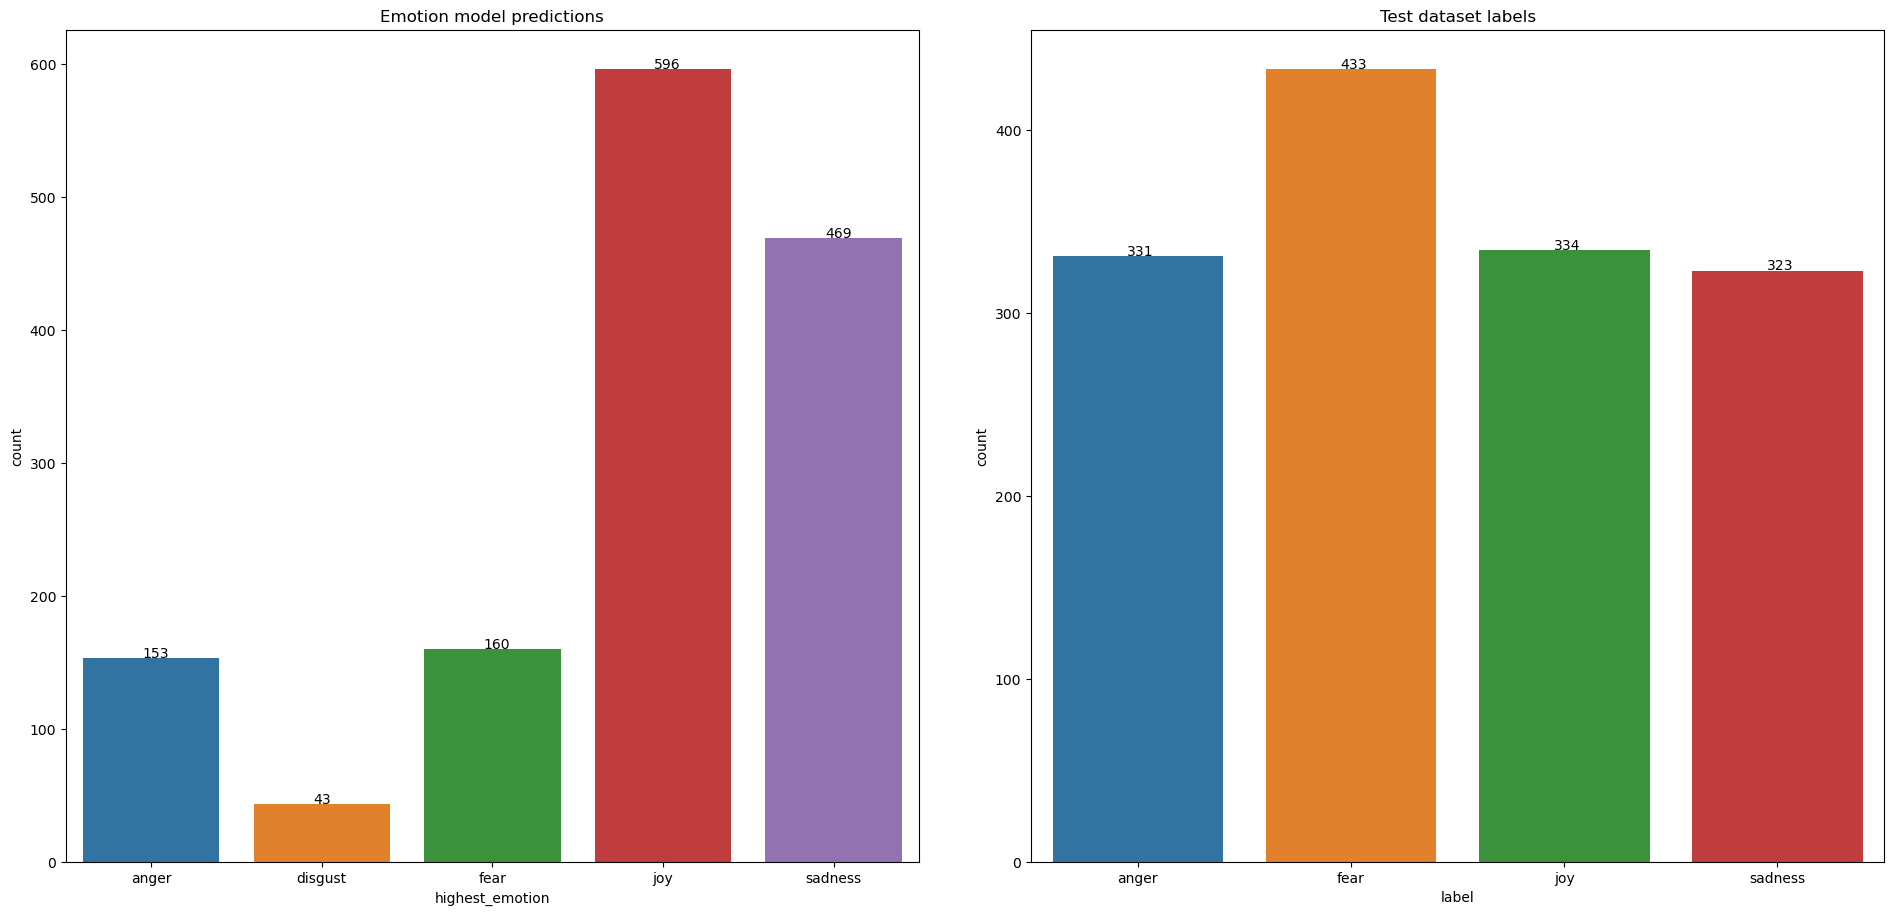

In [18]:
figure, ax = plt.subplots(ncols=2, figsize=(20,10))
figure.tight_layout(pad=5)
sns.countplot(x=emotion_df['highest_emotion'],  data=emotion_df['highest_emotion'], order=emotion_df['highest_emotion'].value_counts().sort_index().index, ax=ax[0])
for p, label in zip(ax[0].patches, emotion_df['highest_emotion'].value_counts().sort_index()): 
    ax[0].annotate(label, (p.get_x()+0.35, p.get_height()+0.5))
ax[0].set_title('Emotion model predictions')

sns.countplot(x=test_df["label"],  data=test_df["label"], order=test_df["label"].value_counts().sort_index().index, ax=ax[1])
for p, label in zip(ax[1].patches, test_df["label"].value_counts().sort_index()):   
    ax[1].annotate(label, (p.get_x()+0.35, p.get_height()+0.5))
ax[1].set_title('Test dataset labels')

## 6. Summary

<span style="color:blue">This notebook shows you how to use the Watson NLP library and how quickly and easily you can get started with Watson NLP by running the pretrained models for emotion analysis.

Please note that this content is made available by IBM Build Lab to foster Embedded AI technology adoption. The content may include systems & methods pending patent with USPTO and protected under US Patent Laws. For redistribution of this content, IBM will use release process. For any questions please log an issue in the hosting [GitHub](https://github.com/ibm-ecosystem-engineering/Watson-NLP) repository. 

Developed by IBM Build Lab 

Copyright - 2023 IBM Corporation 